In [1]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from scipy.stats import uniform
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.ensemble import GradientBoostingRegressor
from random import randint
from sklearn.preprocessing import MinMaxScaler

# 1. Import Data

In [2]:
train_data = pd.read_csv("combined_train_with_features.csv")
valid_data = pd.read_csv("combined_valid_with_features.csv")

In [3]:
train_data.shape

(180, 103)

# 2. Cross Validation on Training Data

In [6]:
def split_data_index(data, K):
    '''
    This function is to split the data index for cross validation
    '''
    index_arr = data.index.values
    shuffle_index_arr = copy.copy(index_arr)
    
    random.seed(222)
    shuffle_index_arr = shuffle_index_arr.reshape(-1,K)
    for arr in shuffle_index_arr:
        random.shuffle(arr)
    
    cv_outer = []
    for i in range(K):

        test_index = shuffle_index_arr[:,i]
        train_index = np.delete(shuffle_index_arr, i, axis=1).reshape(1,-1)[0]

        cv_outer.append([train_index, test_index])
    
    return cv_outer

In [7]:
def MAE(y, y_pred):
    # y, y_pred are numpy.ndarray
    mae = sum(abs(y-y_pred)) / len(y)
    return mae

In [8]:
def performance_eval(cv_outer, data):
    
    MAE_results = []
    RMSE_results = []
    MedAE_results = []
    r2_results = []
    model_params = []
    
    for train_index, test_index in cv_outer:
        
        X_train, y_train = data.iloc[train_index,6:].values, data.iloc[train_index,3].values
        X_test, y_test = data.iloc[test_index,6:].values, data.iloc[test_index,3].values
        
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

        model = GradientBoostingRegressor(random_state=222)
        
        params = {'n_estimators': np.arange(10,300,10),
                  'max_depth': np.arange(1, 5, 1),
                  'learning_rate': np.arange(0.005, 0.2, 0.001),   
                    }

        search = RandomizedSearchCV(model,params,cv=cv_inner,scoring='neg_mean_absolute_error',verbose=0,n_jobs=-1,n_iter=100,refit=False,\
                                   random_state=999)
        search.fit(X_train, y_train)
        
        model_params.append(search.best_params_)
    
        model.set_params(**search.best_params_)
        model.fit(X_train, y_train)
        print(search.best_params_)
        y_pred = model.predict(X_test)
        
        mae = MAE(y_test, y_pred)
        MAE_results.append(mae)
        
        rmse = mean_squared_error(y_test,y_pred,squared=False)
        RMSE_results.append(rmse)
        
        med = median_absolute_error(y_test, y_pred)
        MedAE_results.append(med)
        
        r2 = r2_score(y_test, y_pred)
        r2_results.append(r2)
        
    
    return MAE_results, RMSE_results, MedAE_results, r2_results, model_params

In [9]:
cv_outer = split_data_index(train_data, 10)
MAE_results, RMSE_results, MedAE_results, r2_results, model_params = performance_eval(cv_outer, train_data)

{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.15}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600000000000001}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.116}
{'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.18000000000000002}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.097}


In [1]:
# MAE_results

# np.mean(MAE_results)

# RMSE_results

# np.mean(RMSE_results)

# np.mean(r2_results)

# model_params

# 3. Test on Validation Set

In [16]:
X_train = train_data.iloc[:,6:].values
y_train = train_data.iloc[:,3].values
X_valid = valid_data.iloc[:,6:].values
y_valid = valid_data.iloc[:,3].values

In [18]:
def predict_validation(model_params, X_train, y_train, X_valid, y_valid):
    
    predictions = []
    importances = []
    permutation = []
    
    for param in model_params:
        model = GradientBoostingRegressor(random_state=222)
        model.set_params(**param)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)
        predictions.append(y_pred)

    y_hat = list(map(lambda x: sum(x)/len(x), np.array(predictions).T))

    return y_hat

In [19]:
y_hat = predict_validation(model_params, X_train, y_train, X_valid, y_valid)

In [20]:
r2 = r2_score(y_valid, y_hat)

In [21]:
r2

0.9920774585342907

In [22]:
mean_squared_error(y_valid, y_hat,squared=False)

0.20607984825722017

In [23]:
MAE(y_valid, y_hat)

0.1522491473734683

In [24]:
median_absolute_error(y_valid, y_hat)

0.10299220104309725

# 4. Plot y_true and y_pred

Text(0, 0.5, 'Predicted Retention Time (min)')

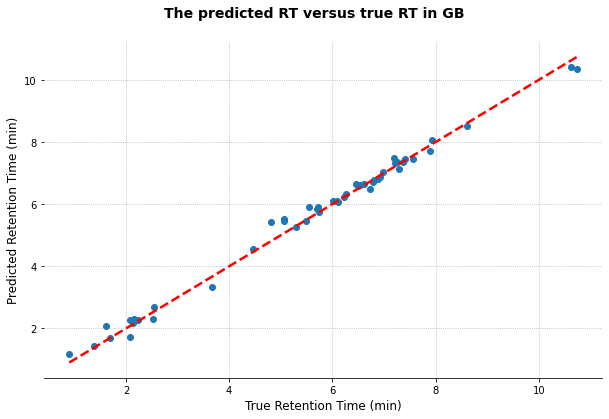

In [26]:
fig, ax = plt.subplots(figsize=(10,6.18))
fig.patch.set_facecolor('white')
ax.grid(True, which='major', linestyle=':')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(y_valid, y_hat, 'o')
ax.plot(y_valid, y_valid, '--', color='red', linewidth=2.5)
# ax.legend()

fig.suptitle("The predicted RT versus true RT in GB", y=0.96, fontsize=14, fontweight='bold')
ax.set_xlabel("True Retention Time (min)", fontdict={'fontsize': 12})
ax.set_ylabel("Predicted Retention Time (min)", fontdict={'fontsize': 12})


# fig.savefig("GB_validation_pred_true.png", dpi=300)

In [27]:
pred_df = pd.DataFrame(y_hat)

In [28]:
pred_df.columns = ['GB_pred']

In [29]:
pred_df.to_csv("Combined_Validation_Predict_GB.csv", index=False)